In [94]:
import argparse
import json

from torch.utils.data import DataLoader

from models import *
from utils.datasets import *
from utils.utils import *


def test(cfg,
         data,
         weights=None,
         batch_size=16,
         img_size=416,
         conf_thres=0.001,
         iou_thres=0.5,  # for nms
         save_json=False,
         single_cls=False,
         model=None,
         dataloader=None):
    print(weights)
    device = torch_utils.select_device('', batch_size=batch_size)
    verbose = True
    # Remove previous
    for f in glob.glob('test_batch*.jpg'):
        os.remove(f)

    # Initialize model
    model = Darknet(cfg, img_size).to(device)
    print(weights)
    # Load weights
    attempt_download(weights)
    if weights.endswith('.pt'):  # pytorch format
        model.load_state_dict(torch.load(weights, map_location=device)['model'])
    else:  # darknet format
        load_darknet_weights(model, weights)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    data = parse_data_cfg(data)
    nc = 1 if single_cls else int(data['classes'])  # number of classes
    path = data['valid']  # path to test images
    #path = data['test']  # path to test images
    names = load_classes(data['names'])  # class names
    #iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    iouv = torch.linspace(0.25, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if dataloader is None:
        dataset = LoadImagesAndLabels(path, img_size, batch_size, rect=True)
        batch_size = min(batch_size, len(dataset))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                num_workers=min([os.cpu_count(), \
                                                 batch_size if batch_size > 1 else 0, 8]),
                                pin_memory=True,
                                collate_fn=dataset.collate_fn)

    seen = 0
    model.eval()
    coco91class = coco80_to_coco91_class()
    s = ('%20s' + '%10s' * 6) % ('Class', 'Images', 'Targets', 'P', 'R', 'mAP@0.25', 'F1')
    p, r, f1, mp, mr, map, mf1 = 0., 0., 0., 0., 0., 0., 0.
    loss = torch.zeros(3)
    jdict, stats, ap, ap_class = [], [], [], []
    for batch_i, (imgs, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
        if(batch_i>50):
            break
        imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0
        targets = targets.to(device)
        _, _, height, width = imgs.shape  # batch size, channels, height, width

        # Plot images with bounding boxes
        if batch_i == 0 and not os.path.exists('test_batch0.png'):
            plot_images(imgs=imgs, targets=targets, paths=paths, fname='test_batch0.png')


        # Disable gradients
        with torch.no_grad():
            # Run model
            inf_out, train_out = model(imgs)  # inference and training outputs

            # Compute loss
            if hasattr(model, 'hyp'):  # if model has loss hyperparameters
                loss += compute_loss(train_out, targets, model)[1][:3].cpu()  # GIoU, obj, cls

            # Run NMS
            output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres)

        # Statistics per image
        for si, pred in enumerate(output):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            seen += 1

            if pred is None:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool),
                                  torch.Tensor(), torch.Tensor(), tcls))
                continue

            # Append to text file
            # with open('test.txt', 'a') as file:
            #    [file.write('%11.5g' * 7 % tuple(x) + '\n') for x in pred]

            # Clip boxes to image bounds
            clip_coords(pred, (height, width))

            # Append to pycocotools JSON dictionary
            if save_json:
                # [{"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78],
                # "score": 0.236}, ...
                image_id = int(Path(paths[si]).stem.split('_')[-1])
                box = pred[:, :4].clone()  # xyxy
                # to original shape
                scale_coords(imgs[si].shape[1:], box, shapes[si][0], shapes[si][1])  
                box = xyxy2xywh(box)  # xywh
                box[:, :2] -= box[:, 2:] / 2  # xy center to top-left corner
                for di, d in enumerate(pred):
                    jdict.append({'image_id': image_id,
                                  'category_id': coco91class[int(d[5])],
                                  'bbox': [floatn(x, 3) for x in box[di]],
                                  'score': floatn(d[4], 5)})
                    pass
                pass

            # Assign all predictions as incorrect
            correct = torch.zeros(len(pred), niou, dtype=torch.bool)
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]

                # target boxes
                tbox = \
                    xywh2xyxy(labels[:, 1:5]) * torch.Tensor([width, height, width, height]).to(device)

                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero().view(-1)  # prediction indices
                    pi = (cls == pred[:, 5]).nonzero().view(-1)  # target indices
                    # Search for detections
                    if len(pi):
                        # Prediction to target ious
                        ious, i = box_iou(pred[pi, :4], tbox[ti]).max(1)  # best ious, indices
                        # Append detections
                        for j in (ious > iouv[0]).nonzero():
                            d = ti[i[j]]  # detected target
                            if d not in detected:
                                detected.append(d)
                                correct[pi[j]] = (ious[j] > iouv).cpu()  # iou_thres is 1xn
                                pass
                            pass
                        pass
            # Append statistics (correct, conf, pcls, tcls)
            stats.append((correct, pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
            pass
        pass


    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    result = stats
    if len(stats):
        p, r, ap, f1, ap_class = ap_per_class(*stats)
        if niou > 1:
            p, r, ap, f1 = p[:, 0], r[:, 0], ap.mean(1), ap[:, 0]  # [P, R, AP@0.5:0.95, AP@0.5]
        mp, mr, map, mf1 = p.mean(), r.mean(), ap.mean(), f1.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)

    # Print results
    pf = '%20s' + '%10.3g' * 6  # print format
    print(pf % ('all', seen, nt.sum(), mp, mr, map, mf1))

    # Print results per class
    if verbose and nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap[i], f1[i]))

    # Save JSON
    if save_json and map and len(jdict):
        imgIds = [int(Path(x).stem.split('_')[-1]) for x in dataloader.dataset.img_files]
        with open('results.json', 'w') as file:
            json.dump(jdict, file)

        try:
            from pycocotools.coco import COCO
            from pycocotools.cocoeval import COCOeval
        except:
            print('WARNING: missing pycocotools package, can not compute official COCO mAP.\
            See requirements.txt.')
    # Return results
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return result

In [95]:
def my_ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (nparray, nx1 or nx10).
        conf:  Objectness value from 0-1 (nparray).
        pred_cls: Predicted object classes (nparray).
        target_cls: True object classes (nparray).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    labels = ["buildings" ,"small aircraft", 
          "large aircraft","vehicles","bus","boat"]

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)
    # Create Precision-Recall curve and compute AP for each class
    # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
    s = [len(unique_classes), tp.shape[1]]  
    ap, p, r = np.zeros(s), np.zeros(s), np.zeros(s)
    plt.figure(dpi=80,figsize=(5,5))
    print("{:15},{:10},{:10},{:10},{:10},{:10}".format("label","    n_gt","  n_preds",
                                                 "    tp","     fp","  mAP@0.25"))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects
        if n_p == 0 or n_gt == 0:
            continue
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum(0)
            tpc = tp[i].cumsum(0)
            
            
            tp_sum = tp[i].sum(0)
            fp_sum = (1 - tp[i]).sum(0)
            print("{:15},{:10},{:10},{:10},{:10},{:10}".format(labels[int(c)],n_gt,len(tp[i]),
                                                   int(tp_sum),int(fp_sum), str(tp_sum/(tp_sum+fp_sum) ) ))
            
            # Recall
            recall = tpc / (n_gt + 1e-16)  # recall curve
            r[ci] = recall[-1]
            # Precision
            precision = tpc / (tpc + fpc)  # precision curve
            p[ci] = precision[-1]
            
            # AP from recall-precision curve
            for j in range(tp.shape[1]):
                ap[ci, j] = compute_ap(recall[:, j], precision[:, j])
            # Plot

            plt.plot(recall,precision,label=labels[int(c)])
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title("model performance")
            plt.xlim(0,1)
            plt.xlim(0,1)
            pass
        pass
    plt.legend()
    plt.show()


    # Compute F1 score (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype('int32')

## Evaluation of 30cm performance

In [96]:
# Test
stats = test(cfg='cfg/yolov3-spp.cfg',
         data='/data/zjc4/chipped-30/xview_data.txt',
         weights='weights/best-30.pt',
         batch_size=32,
         img_size=416,
         conf_thres=0.001,
         iou_thres=0.25,
         save_json=True)


weights/best-30.pt
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11178MB)
           device1 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11177MB)









               Class    Images   Targets         P         R  mAP@0.25        F1:   0%|          | 0/1 [00:00<?, ?it/s]

weights/best-30.pt








               Class    Images   Targets         P         R  mAP@0.25        F1: 100%|██████████| 1/1 [00:53<00:00, 53.70s/it]


                 all        32  2.17e+04     0.109     0.254     0.208     0.115
                 b&f        32  1.31e+04     0.446     0.453     0.347      0.45
                  sa        32         1         0         0         0         0
                  la        32        22     0.061     0.955     0.857     0.115
                 veh        32  6.99e+03         0         0         0         0
                 bus        32  1.19e+03    0.0258    0.0118   0.00528    0.0162
                boat        32       344     0.122     0.102    0.0401     0.111


label          ,    n_gt  ,  n_preds ,    tp    ,     fp   ,  mAP@0.25
buildings      ,     13114,     13321,      5946,      7375,[    0.44636]
small aircraft ,         1,        24,         0,        24,[          0]
large aircraft ,        22,       344,        21,       323,[   0.061047]
vehicles       ,      6988,        63,         0,        63,[          0]
bus            ,      1189,       542,        14,       528,[    0.02583]
boat           ,       344,       287,        35,       252,[    0.12195]


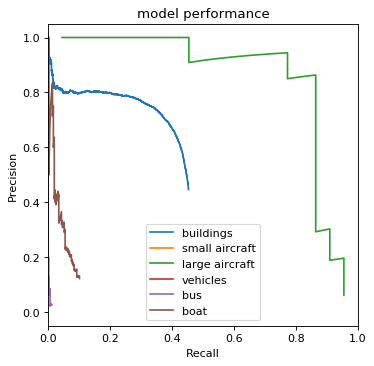

In [97]:
p, r, ap, f1, ap_class = my_ap_per_class(*stats)

In [99]:
p

array([[    0.44636],
       [          0],
       [   0.061047],
       [          0],
       [    0.02583],
       [    0.12195]])

In [100]:
p

array([[    0.44636],
       [          0],
       [   0.061047],
       [          0],
       [    0.02583],
       [    0.12195]])

## Evaluation of 90cm performance

In [81]:
# Test
stats = test(cfg='cfg/yolov3-spp.cfg',
         data='/data/zjc4/chipped-90/xview_data.txt',
         weights='weights/best-90.pt',
         batch_size=32,
         img_size=416,
         conf_thres=0.001,
         iou_thres=0.25,
         save_json=True)


weights/best-90.pt
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11178MB)
           device1 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11177MB)

weights/best-90.pt








               Class    Images   Targets         P         R  mAP@0.25        F1:   0%|          | 0/2 [00:00<?, ?it/s]





               Class    Images   Targets         P         R  mAP@0.25        F1:  50%|█████     | 1/2 [01:44<01:44, 104.63s/it]





               Class    Images   Targets         P         R  mAP@0.25        F1: 100%|██████████| 2/2 [01:45<00:00, 52.64s/it] 


                 all        34  2.58e+04    0.0716     0.217      0.18    0.0934
                 b&f        34  1.22e+04     0.319     0.455     0.356     0.375
                  sa        34        55   0.00351    0.0182  8.88e-05   0.00588
                  la        34        48    0.0959     0.771     0.671     0.171
                 veh        34  1.15e+04         0         0         0         0
                 bus        34  1.99e+03    0.0092   0.00352  9.55e-05   0.00509
                boat        34        19   0.00194    0.0526     0.055   0.00374


label          ,    n_gt  ,  n_preds ,    tp    ,     fp   ,  mAP@0.25
buildings      ,     12172,     17348,      5538,     11810,[    0.31923]
small aircraft ,        55,       285,         1,       284,[  0.0035088]
large aircraft ,        48,       386,        37,       349,[   0.095855]
vehicles       ,     11509,        32,         0,        32,[          0]
bus            ,      1991,       761,         7,       754,[  0.0091984]
boat           ,        19,       516,         1,       515,[   0.001938]


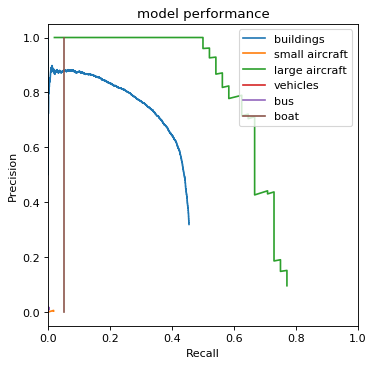

In [82]:
p, r, ap, f1, ap_class = my_ap_per_class(*stats)

In [83]:
p

array([[    0.31923],
       [  0.0035088],
       [   0.095855],
       [          0],
       [  0.0091984],
       [   0.001938]])

In [45]:
import os

In [51]:
os.system("cp /data/zjc4/chipped-90/data/images/002391_00.jpg /data/zjc4/detect-90/" )
os.system("cp /data/zjc4/chipped-30/data/images/002391_00.jpg /data/zjc4/detect-30/" )

0

In [52]:
(os.system("python3 detect.py --weights weights/best-90.pt --source /data/zjc4/detect-90 --output output_90/"))
(os.system("python3 detect.py --weights weights/best-30.pt --source /data/zjc4/detect-30 --output output_30/"))

0